In [65]:
import numpy as np
import pandas as pd
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import validation_curve, learning_curve


# A real-world example

We're going to take a look at data on COVID coverage by local news agencies in the US.

There are a number of features in this dataset, there's a more detailed description of most of them [here](https://arxiv.org/pdf/2111.08515.pdf). I'll describe what we're using here, though, obviusly

*Note: I am, again, using data that I have used for research in the past. I think it is useful, because I am able to provide more thoughtful responses to questions and comments about the data and methods. It is not because I think my research is especially great, or that you should read it.*

In [2]:
covid_df = pd.read_csv("covid_local_news.csv")

## Walking the ML Pipeline



In [3]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "http://www-student.cse.buffalo.edu/~atri/algo-and-society/support/notes/pipeline/images/ML-pipeline-duame-soc.png",
     width=800)


### Real world goal

Find local news deserts. In other words, find places where people aren('t) likely to be getting adequate news about COVID


### Real world mechanism

Identify places where **<span style="color:red">the number of articles that cover COVID</span>** is low. We can then try to forecast coverage in locations where we don't have data.



In [4]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "./coverage.png", width=600, height=600)

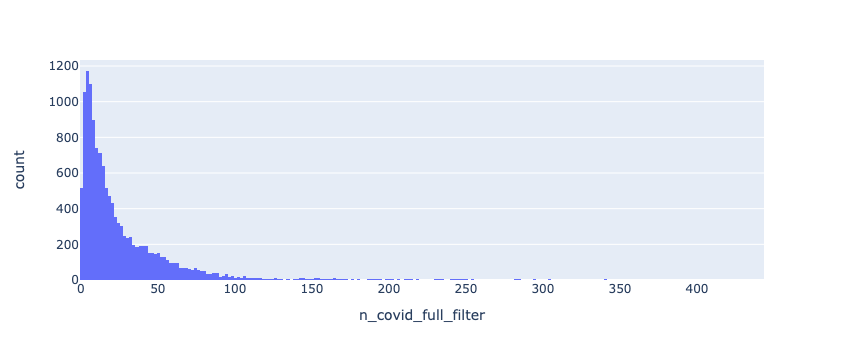

In [5]:
px.histogram(covid_df, x="n_covid_full_filter")

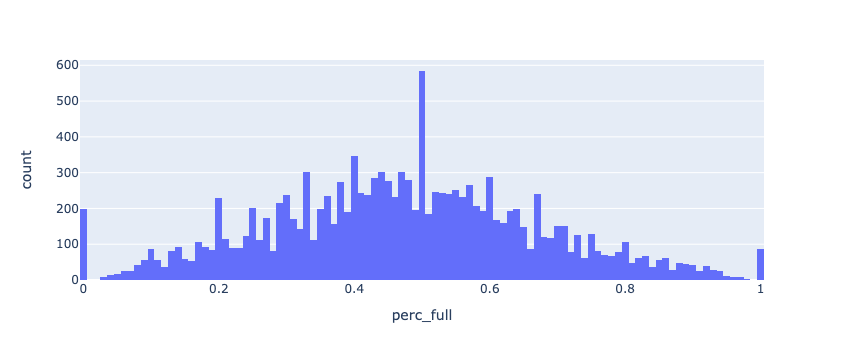

In [6]:
px.histogram(covid_df, x="perc_full")

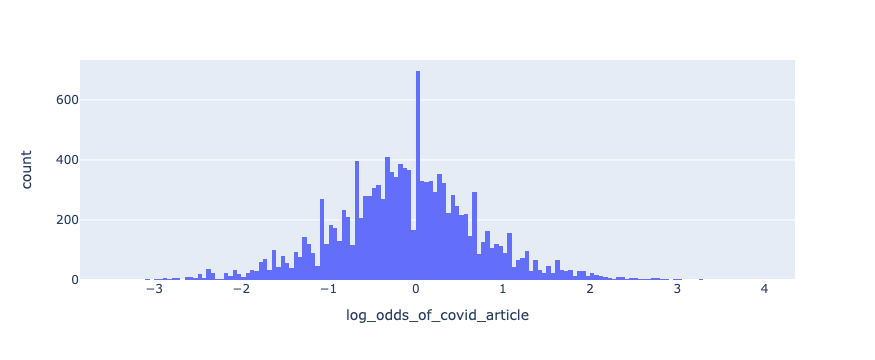

In [7]:
covid_df['log_odds_of_covid_article'] = np.log((covid_df.n_covid_full_filter+1)/(covid_df.n_total_articles-covid_df.n_covid_full_filter+1))
px.histogram(covid_df, x="log_odds_of_covid_article")

## Learning problem

Predict the percentage of weekly coverage devoted to COVID for local news outlets across the country that make data available

## Data Collection

- RSS Feeds (You can have data like this, [from here](https://benjamindhorne.github.io/data.html). We might play with some later in the semester)
- U.S. Census Bureau
- A bunch of random Githubs :)

## Data Representation

Below, we display the first five rows of the data...

In [8]:
pd.set_option('display.max_columns', None)
covid_df.head()

fips_full  fips    state  week_num  fips_covid  \
0       1013  1013  Alabama        14        1013   
1       1013  1013  Alabama        15        1013   
2       1013  1013  Alabama        16        1013   
3       1013  1013  Alabama        17        1013   
4       1013  1013  Alabama        18        1013   

                             sourcedomain_id        lon        lat  \
0  greenvilleadvocate-greenvilleadvocate.com -86.617752  31.829597   
1  greenvilleadvocate-greenvilleadvocate.com -86.617752  31.829597   
2  greenvilleadvocate-greenvilleadvocate.com -86.617752  31.829597   
3  greenvilleadvocate-greenvilleadvocate.com -86.617752  31.829597   
4  greenvilleadvocate-greenvilleadvocate.com -86.617752  31.829597   

                     title       rank  n_total_articles  \
0  The Greenville Advocate  1510346.0                 4   
1  The Greenville Advocate  1510346.0                11   
2  The Greenville Advocate  1510346.0                 1   
3  The Greenville Advocate  1510346.0                12   
4  The Greenville Advocate  1510346.0                 3   

   n_covid_limited_filter  n_covid_full_filter  fips_cum_cases  \
0                       2                    4               8   
1                       1                    7              16   
2                       0                    1              45   
3                       3                    7             120   
4                       1                    3             224   

   fips_cum_deaths  fips_lag1_cum_cases  fips_lag2_cum_cases  fips_n_cases  \
0                0                    2                    1             6   
1                0                    8                    2             8   
2                1                   16                    8            29   
3                2                   45                   16            75   
4                6                  120                   45           104   

   fips_lag1_n_cases  fips_lag1_cum_deaths  fips_lag2_cum_deaths  \
0                  1                     0                     0   
1                  6                     0                     0   
2                  8                     0                     0   
3                 29                     1                     0   
4                 75                     2                     1   

   fips_n_deaths  fips_lag1_n_deaths  state_cum_cases  state_cum_deaths  \
0              0                   0             3955               115   
1              0                   0             5350               195   
2              1                   0             6752               245   
3              1                   1             8438               317   
4              4                   1            10464               436   

   state_lag1_cum_cases  state_lag2_cum_cases  state_n_cases  \
0                  2200                  1008           1755   
1                  3955                  2200           1395   
2                  5350                  3955           1402   
3                  6752                  5350           1686   
4                  8438                  6752           2026   

   state_lag1_n_cases  state_lag1_cum_deaths  state_lag2_cum_deaths  \
0                1192                     64                     14   
1                1755                    115                     64   
2                1395                    195                    115   
3                1402                    245                    195   
4                1686                    317                    245   

   state_n_deaths  state_lag1_n_deaths country  country_cum_cases  \
0              51                   50     USA             604363   
1              80                   51     USA             804845   
2              50                   80     USA            1012453   
3              72                   50     USA            1203928   
4             119        

In general, here, we would also work to clean up our data for analysis - rescaling features, dropping features, one-hot encoding, etc.  For the purposes of this notebook, though, where we're going to do some exploration, I'm going to leave that to the modeling section

## Target Class/Model

We're going to stick with linear regression for now, but we can choose to add noon-linear . Now we know what that is! And how to optimize it (although we'll use the `sklearn` implementation 

## Training dataset


### Picking a "good" training dataset ... getting us started
Next week, we'll cover model evaluation in more detail. For now, we're just going to note that to ensure our model is generalizable and not overfit to the training data, we need to separate out a training dataset from a test dataset.

**Exercise:** Give a high-level argument for why evaluating on the training data is a bad idea

With *temporal* data, and more generally, data with dependencies, it is also important that we make sure that we are avoiding the leakage of information from the training data in a way that creates a biased understanding of how well we are making predictions. Leakage can happen in at least two ways (again, we'll go into more detail next week):

- We have a feature for a given exmple that wouldn't be available in the real world **exercise:** what's an example here?
- (The trickier one, and informally) We use training data that is somehow correlated with the test data in ways that reveal a pattern to the model that it would not otherwise know. (I'll give an example here).


For this simple example, for now, we're going to ignore the leakage issue. We'll come back and fix that next week

### Picking ... a dataset

Neat! But to pick a good training dataset, we first need to know ... what our dataset is. This data has *a lot* of features. In class, we'll play with a bunch of them, together. Here, I'm just going to get us started

In [9]:
CONTINUOUS_FEATURES = ["state_lag1_n_cases_per1k",
"fips_lag1_n_cases_per1k",
"country_lag1_n_cases_per1k",
"predrt_0"]

OUTCOME = 'log_odds_of_covid_article'


X = covid_df[CONTINUOUS_FEATURES]
y = covid_df[OUTCOME]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

## Model training

OK, let's have at it!


In [10]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

# Predict on Test Data


In [11]:
predictions = model.predict(X_test)

# Evaluate error

In [12]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test,predictions)

0.6643640375053314

# Deploy (?)

What might we be asking ourselves before we deploy?  What might we try to change? Let's work on it!

**In class exercise ... beat Kenny's predictive model!**

# The missing steps in the pipeline

The above pipeline is a barebones representation. In reality, we are trying a bunch of different models, data representations, and even questions, before we deploy.  Here's a representation of the pipeline that trends further towards that, from [this tweet]().


In [13]:
Image(url="https://pbs.twimg.com/media/FKtEyl5XEAABdEa?format=jpg&name=4096x4096", width=800)

Let's look at how we might do some of these other steps

## Exploratory Data Analysis (EDA)

### Basic plotting and stats

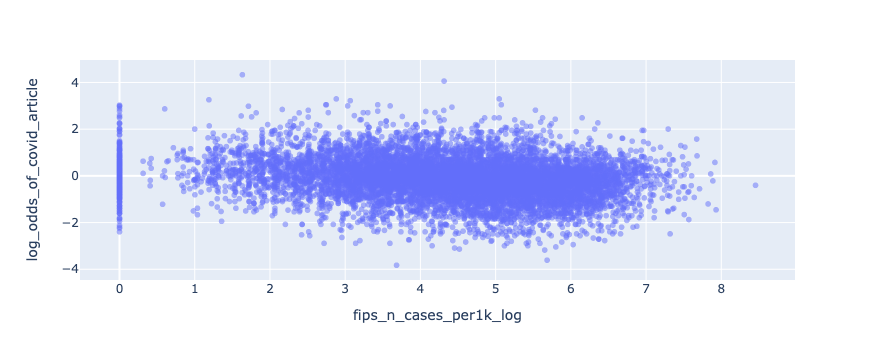

In [14]:
px.scatter(covid_df.sample(10000),
           x='fips_n_cases_per1k_log',
           y='log_odds_of_covid_article',
           opacity=.5
           )

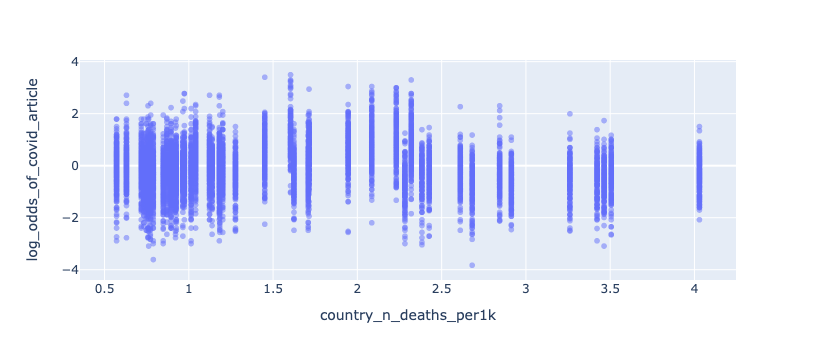

In [15]:
px.scatter(covid_df.sample(10000),
           x='country_n_deaths_per1k',
           y='log_odds_of_covid_article',
           opacity=.5
           )

In [16]:
from scipy.stats import pearsonr

pearsonr(covid_df.country_n_deaths_per1k, covid_df.log_odds_of_covid_article )

(-0.03008625943248823, 0.0004817002592877463)

In [17]:
pearsonr(covid_df.fips_n_deaths_per1k, covid_df.log_odds_of_covid_article )

(-0.009869673637258653, 0.2522552434237165)

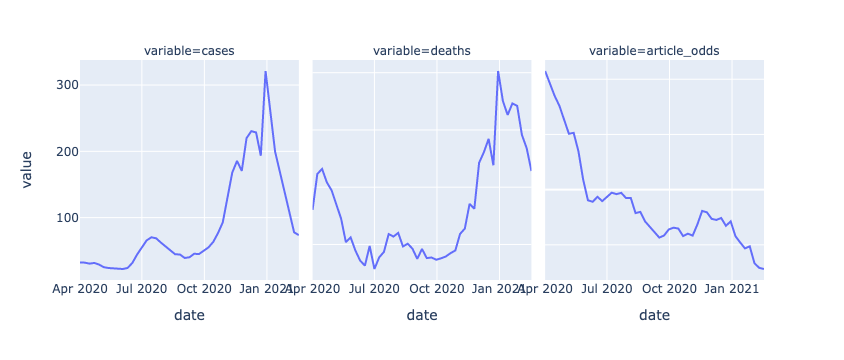

In [18]:
averaged_data = covid_df.groupby("date").agg(
        cases = pd.NamedAgg("country_n_cases_per1k","first"),
        deaths = pd.NamedAgg("country_n_deaths_per1k","first"),
        article_odds = pd.NamedAgg("log_odds_of_covid_article","mean")
).reset_index()
fig = px.line(pd.melt(averaged_data,id_vars="date"),x="date",y="value",facet_col="variable")
fig.update_yaxes(matches=None)
fig.show()

### Using a simple model

One other form of EDA that I personally often leverage is to fit a simple (usually linear) model to the data and explore the coefficients for indicators of what effects might exist.

As we have now discussed in class, thouhg, we have to be really careful when *interpreting coefficients for models with transformed predictor variables*. [Here, for example, is a useful resource for your programming assignment](https://cscu.cornell.edu/wp-content/uploads/83_logv.pdf).

In our case, we actually ended up using a variable that means interpreting our coefficients using interpretations for logistic regression. [Here](https://stats.oarc.ucla.edu/other/mult-pkg/faq/general/faq-how-do-i-interpret-odds-ratios-in-logistic-regression/) is a good explanation. We will cover this in more detail next week, but a simple plot below to discuss!

**Exercise:** Are the estimates from the coefficients we used comparable? Which are, and which are not? What might we do to make them even more comparable?

For this demo, I took code from [this sklearn tutorial](https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html). The tutorial is very nice, I would highly recommend going through it, although *I will teach most of what is in this over the next week or two in one way or another*.

In [19]:
feature_names = CONTINUOUS_FEATURES

coefs = pd.DataFrame(
    model.coef_,
    columns=["Coefficients"],
    index=feature_names,
)

coefs

Coefficients
state_lag1_n_cases_per1k        0.000557
fips_lag1_n_cases_per1k        -0.000172
country_lag1_n_cases_per1k     -0.002770
predrt_0                       -0.013255

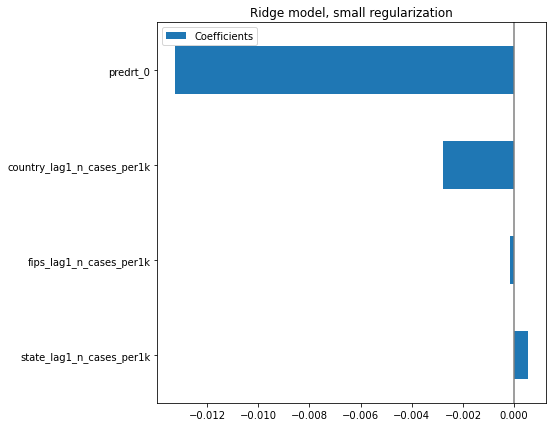

In [20]:
import matplotlib.pyplot as plt
coefs.plot(kind="barh", figsize=(9, 7))
plt.title("Ridge model, small regularization")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

In [21]:
coefs['odds_ratio'] = np.exp(coefs.Coefficients)

In [22]:
coefs

Coefficients  odds_ratio
state_lag1_n_cases_per1k        0.000557    1.000557
fips_lag1_n_cases_per1k        -0.000172    0.999828
country_lag1_n_cases_per1k     -0.002770    0.997234
predrt_0                       -0.013255    0.986832

# Validation Demos

Some of the other things we've discussed in class don't fit neatly within a real-world ML pipeline, but are useful to show on this dataset... these are now in this section below

## k-Fold Cross-validation

In [ ]:
from sklearn.model_selection import cross_val_score
%timeit  cross_val_score(model, X_train, y_train, cv=10)

In [157]:
%timeit  cross_val_score(model, X_train, y_train, cv=100)

303 ms ± 39.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)



### Learning Curves (And, an intro to pipelines)


In [230]:

CONTINUOUS_FEATURES = ["state_lag1_n_cases_per1k",
"fips_lag1_n_cases_per1k",
"country_lag1_n_cases_per1k",
"predrt_0", "week_num", "lo_trump_vote"
]

CATEGORICAL_VARS = ['state']
 
OUTCOME = 'log_odds_of_covid_article'

covid_df = covid_df.sample(frac=1, random_state=1)
X = covid_df[CONTINUOUS_FEATURES +CATEGORICAL_VARS]
y = covid_df[OUTCOME]

basic_pipeline = make_pipeline(
        ColumnTransformer([('numerical', StandardScaler(), CONTINUOUS_FEATURES),
                           ("categorical", OneHotEncoder(handle_unknown = 'ignore'),
                            CATEGORICAL_VARS)]),
        LinearRegression()
    )

train_sizes, train_scores, valid_scores = learning_curve(
        basic_pipeline, X, y, 
    cv=5,
    scoring="neg_root_mean_squared_error",
    train_sizes=np.linspace(0.05, 1.0, 20),
    random_state=104
)


In [231]:
def gen_curve(scores,curvetype,train_sizes,nfolds,nticks):
    return (pd.DataFrame(scores, 
                 columns = [f"fold_{i}" for i in range(nfolds)])
            .assign(size=train_sizes)
            .assign(curve=[curvetype]*nticks)
         )
learning_curve_data = pd.concat(
    [gen_curve(train_scores,"Training",train_sizes,5,20),
     gen_curve(valid_scores,"Validation",train_sizes,5,20)
    ]
)
learning_curve_plot_data = (pd.melt(learning_curve_data,
                                    id_vars=['size','curve'])
 .groupby(['size','curve'])
 .agg(
    mean=pd.NamedAgg(column="value", aggfunc=np.mean),
    sd=pd.NamedAgg(column="value", aggfunc=np.std)
 )
 .reset_index()
)

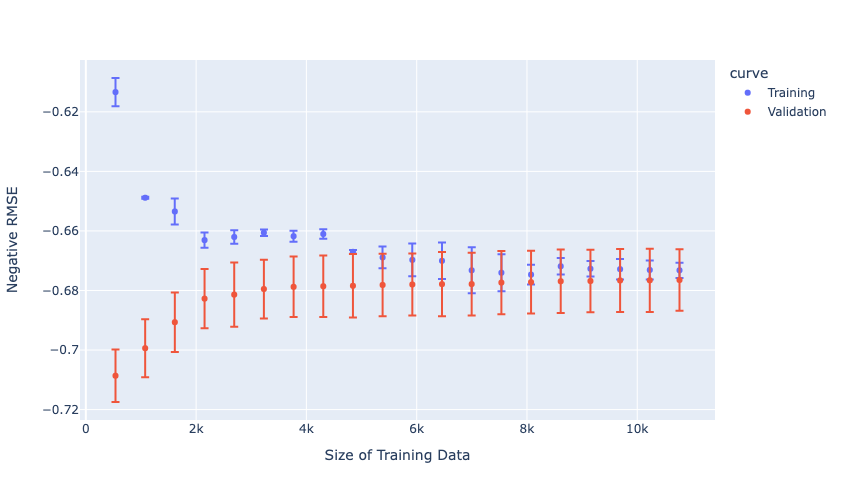

In [232]:

fig = px.scatter(learning_curve_plot_data, 
                 x="size", y="mean", color="curve",
                 error_y="sd",
                labels={
                    "size":"Size of Training Data",
                    "mean" : "Negative MSE"
                },
                height=500,
                width=600)
fig.show()

## kNN Regression and validation curves

In [160]:
np.random.seed(0)
X = np.sort(5 * np.random.rand(40, 1), axis=0)
T = np.linspace(0, 5, 500)[:, np.newaxis]
y = np.sin(X).ravel()

# Add noise to targets
y[::5] += 1 * (0.5 - np.random.rand(8))

/var/folders/rf/4jz25sh1733_8b28phhhrlfh0000gn/T/ipykernel_12153/3751386291.py:7: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



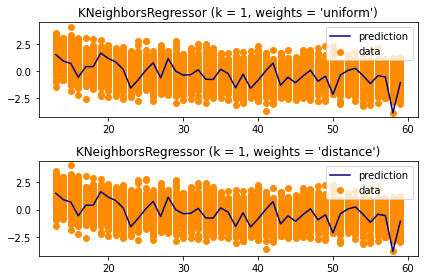

In [212]:
# Generate sample data
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neighbors

cdf = covid_df
X = cdf.week_num[:, np.newaxis]
y = cdf[OUTCOME].values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

srt = list(np.argsort(X_train,axis=0).ravel())
X_train = X_train[srt]
y_train = y_train[srt]
X_test = np.sort(X_test,axis=0)
# #############################################################################
# Fit regression model
n_neighbors = 1

for i, weights in enumerate(["uniform", "distance"]):
    knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
    y_ = knn.fit(X_train, y_train).predict(X_test)

    plt.subplot(2, 1, i + 1)
    plt.scatter(X_train, y_train, color="darkorange", label="data")
    plt.plot(X_test, y_, color="navy", label="prediction")
    plt.axis("tight")
    plt.legend()
    plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (n_neighbors, weights))

plt.tight_layout()
plt.show()

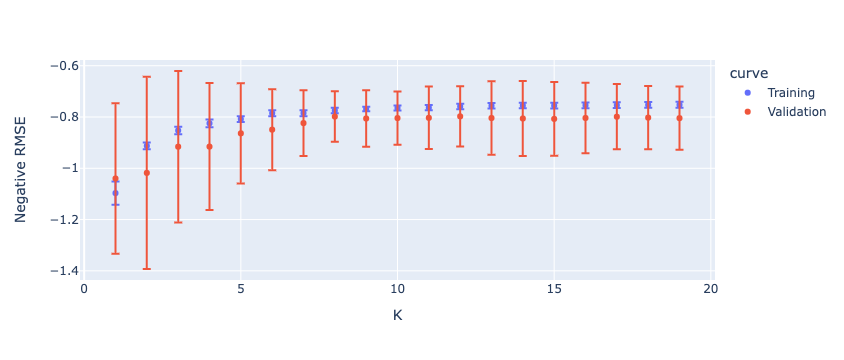

In [234]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve

# #########
param_range = range(1,20)
train_scores, test_scores = validation_curve(
    neighbors.KNeighborsRegressor(),
    X_train,
    y_train,
    param_name="n_neighbors",
    param_range=param_range,
    scoring="neg_root_mean_squared_error",
    n_jobs=2,
    cv=5
)
learning_curve_data = pd.concat(
    [gen_curve(train_scores,"Training",param_range,5,19),
     gen_curve(test_scores,"Validation",param_range,5, 19)
    ]
)
learning_curve_plot_data = (pd.melt(learning_curve_data,
                                    id_vars=['size','curve'])
 .groupby(['size','curve'])
 .agg(
    mean=pd.NamedAgg(column="value", aggfunc=np.mean),
    sd=pd.NamedAgg(column="value", aggfunc=np.std)
 )
 .reset_index()
)


fig = px.scatter(learning_curve_plot_data, 
                 x="size", y="mean", color="curve",
                 error_y="sd",
                labels={
                    "size":"K",
                    "mean" : "Negative RMSE"
                })
fig.show()

Yikes! Compare that to [the standard sklearn example](https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py).

What gives?

# A Full Model Selection Pipeline (Nested CV + Two-way Holdout)

# !!!!!!!! <span style="color:red">Disclaimer: this is a modified version of Sebastian Raschka's demo [here](https://github.com/rasbt/stat451-machine-learning-fs20/blob/master/L11/code/11-eval4-algo__nested-cv_verbose1.ipynb)</span> !!!!!



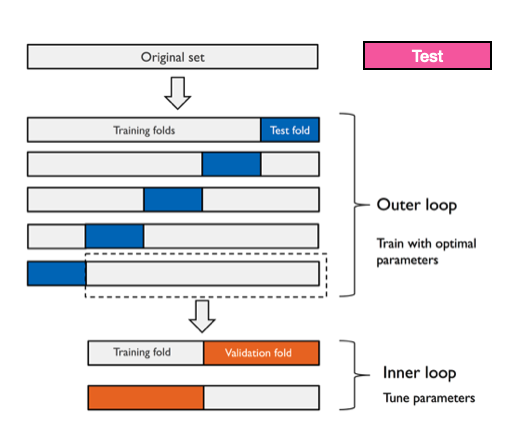

In [236]:
Image("https://github.com/rasbt/stat451-machine-learning-fs20/"+
      "raw/9e463e06a49278a3940774ef32def883e85e9cc0/L11/code/nested-cv-image.png")

In [268]:
import numpy as np
from sklearn.model_selection import GridSearchCV,train_test_split,StratifiedKFold,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

CONTINUOUS_FEATURES = ["state_lag1_n_cases_per1k",
"fips_lag1_n_cases_per1k",
"country_lag1_n_cases_per1k",
"predrt_0",
"lo_trump_vote",
"black_pct",
"white_pct",
"lon",
"lat",
"week_num"
]

CATEGORICAL_VARS = ['state']
 
OUTCOME = 'log_odds_of_covid_article'

covid_df = covid_df.sample(frac=1, random_state=1)
X = covid_df[CONTINUOUS_FEATURES +CATEGORICAL_VARS]
y = covid_df[OUTCOME]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=1)

basic_pipeline = make_pipeline(
        ColumnTransformer([('numerical', StandardScaler(), CONTINUOUS_FEATURES),
                           ("categorical", OneHotEncoder(handle_unknown = 'ignore'),CATEGORICAL_VARS)]),
    )

clf1 = LinearRegression(fit_intercept=True)
clf2 = KNeighborsRegressor()
clf3 = DecisionTreeRegressor(random_state=1)

# Building the pipelines
pipe1 = Pipeline([("pipe",basic_pipeline),
                  ('clf1', clf1)])

pipe2 = Pipeline([("pipe",basic_pipeline),
                  ('clf2', clf2)])

pipe3 = Pipeline([("pipe",basic_pipeline),
                  ('clf3', clf3)])

# Setting up the parameter grids
param_grid1 = [{'clf1__fit_intercept' : [True,False]}]
param_grid2 = [{'clf2__n_neighbors' : [1,2,5,10]}]
param_grid3 = [{'clf3__max_depth': [5,10],
                'clf3__criterion': ["squared_error", "absolute_error"]}]

In [271]:
from sklearn.model_selection import KFold
gridcvs = {}
inner_cv = KFold(n_splits=5, shuffle=True, random_state=1)

for pgrid, est, name in zip((param_grid1, param_grid2, param_grid3),
                            (pipe1, pipe2,pipe3),
                            ('Linear', 'KNN','DT')):
    gcv = GridSearchCV(estimator=est,
                       param_grid=pgrid,
                       scoring='neg_mean_squared_error',
                       cv=inner_cv,
                       verbose=0,
                       refit=True)
    gridcvs[name] = gcv

In [272]:
for name, gs_est in sorted(gridcvs.items()):
    print(50 * '-', '\n')
    print('Algorithm:', name)
    print('    Inner loop:')
    
    outer_scores = []
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)
    
    for train_idx, valid_idx in outer_cv.split(X_train, y_train):
        []
        gridcvs[name].fit(X_train.iloc[train_idx], 
                          y_train.iloc[train_idx]) # run inner loop hyperparam tuning
        print('\n        Best MSE (avg. of inner test folds) {}'.format(gridcvs[name].best_score_ *-1))
        print('        Best parameters:', gridcvs[name].best_params_)
        
        # perf on test fold (valid_idx)
        outer_scores.append(gridcvs[name].best_estimator_.score(X_train.iloc[valid_idx], y_train.iloc[valid_idx]))
        print('        MSE (on outer test fold) %.2f' % (outer_scores[-1]*1))
    
    print('\n    Outer Loop:')
    print('        MSE %.2f +/- %.2f' % 
              (np.mean(outer_scores), np.std(outer_scores)))

-------------------------------------------------- 

Algorithm: DT
    Inner loop:

        Best MSE (avg. of inner test folds) 0.3801930576479365
        Best parameters: {'clf3__criterion': 'squared_error', 'clf3__max_depth': 10}
        MSE (on outer test fold) 0.50

        Best MSE (avg. of inner test folds) 0.385387575033809
        Best parameters: {'clf3__criterion': 'squared_error', 'clf3__max_depth': 10}
        MSE (on outer test fold) 0.48

        Best MSE (avg. of inner test folds) 0.37763460990277814
        Best parameters: {'clf3__criterion': 'absolute_error', 'clf3__max_depth': 10}
        MSE (on outer test fold) 0.46

        Best MSE (avg. of inner test folds) 0.3857138446021934
        Best parameters: {'clf3__criterion': 'squared_error', 'clf3__max_depth': 10}
        MSE (on outer test fold) 0.48

        Best MSE (avg. of inner test folds) 0.38646220655549246
        Best parameters: {'clf3__criterion': 'squared_error', 'clf3__max_depth': 10}
        MSE (on ou

In [278]:
gcv_model_select = GridSearchCV(estimator=pipe1,
                                param_grid=param_grid1,
                                scoring='neg_mean_squared_error',
                                cv=inner_cv,
                                verbose=1,
                                refit=True)

gcv_model_select.fit(X_train, y_train)
print('Best CV MSE: {}'.format(gcv_model_select.best_score_*-1))
print('Best parameters:', gcv_model_select.best_params_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best CV MSE: 0.4552929660458946
Best parameters: {'clf1__fit_intercept': False}


In [279]:
from sklearn.metrics import mean_squared_error
train_mse = mean_squared_error(y_true=y_train, y_pred=gcv_model_select.predict(X_train))
test_mse = mean_squared_error(y_true=y_test, y_pred=gcv_model_select.predict(X_test))

print('Training MSE: {}'.format(train_mse))
print('Test MSE: {}'.format(test_mse))

Training MSE: 0.45028534654415026
Test MSE: 0.43868299320467713


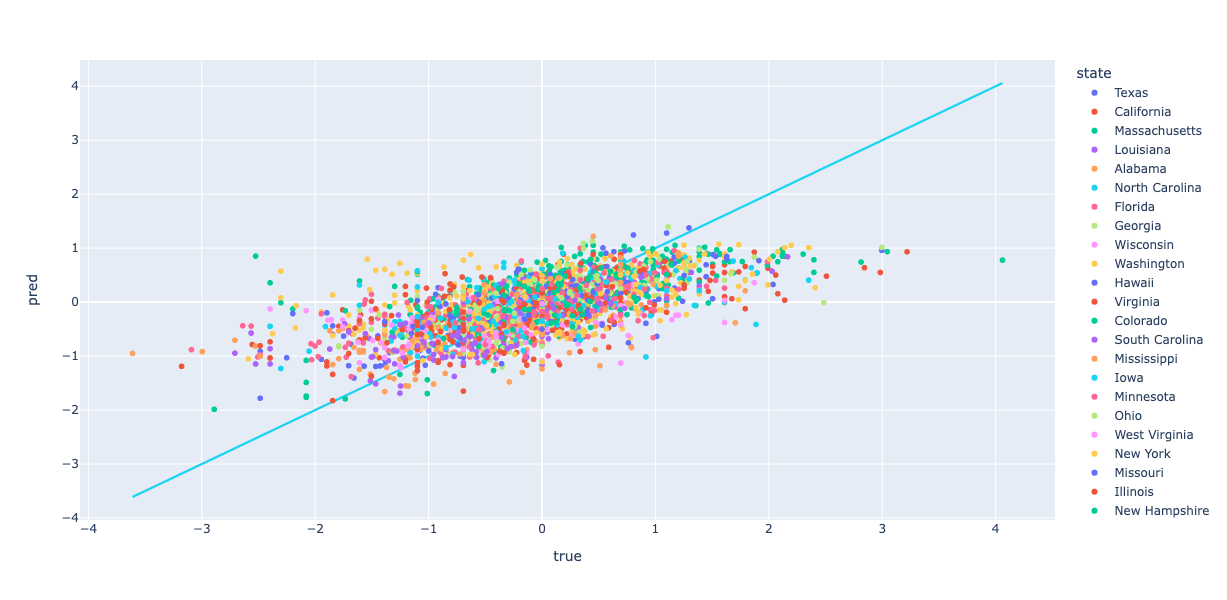

In [293]:
import plotly.graph_objects as go

data = pd.DataFrame({"true":y_test,"pred":gcv_model_select.predict(X_test), "state": X_test.state})
fig = px.scatter(data,x="true",y="pred",color='state',height=600,width=700)
fig.add_trace(
    go.Scatter(x=data['true'], y=data['true'], name="slope", line_shape='linear')
)
fig.show()

# Lasso Example

In [298]:
for x in covid_df.columns:
    print(x)

fips_full
fips
state
week_num
fips_covid
sourcedomain_id
lon
lat
title
rank
n_total_articles
n_covid_limited_filter
n_covid_full_filter
fips_cum_cases
fips_cum_deaths
fips_lag1_cum_cases
fips_lag2_cum_cases
fips_n_cases
fips_lag1_n_cases
fips_lag1_cum_deaths
fips_lag2_cum_deaths
fips_n_deaths
fips_lag1_n_deaths
state_cum_cases
state_cum_deaths
state_lag1_cum_cases
state_lag2_cum_cases
state_n_cases
state_lag1_n_cases
state_lag1_cum_deaths
state_lag2_cum_deaths
state_n_deaths
state_lag1_n_deaths
country
country_cum_cases
country_cum_deaths
country_lag1_cum_cases
country_lag2_cum_cases
country_n_cases
country_lag1_n_cases
country_lag1_cum_deaths
country_lag2_cum_deaths
country_n_deaths
country_lag1_n_deaths
date
county
trump16
clinton16
total_population
white_pct
black_pct
hispanic_pct
age65andolder_pct
lesshs_pct
rural_pct
ruralurban_cc
state_popn
POPESTIMATE2019
country_population
lo_trump_vote_16
fips_n_cases_per1k
fips_n_cases_per1k_log
fips_n_cases_lo
fips_lag1_n_cases_per1k
fips_la

In [332]:
# Write your code for Part 1.2 here
from sklearn.linear_model import Ridge

all_continuous_vars = ["week_num", "lon", "lat", "fips_cum_cases", 
                       "white_pct", "black_pct", "hispanic_pct", 
                       "age65andolder_pct", "lesshs_pct", "rural_pct", "ruralurban_cc", "state_popn", "POPESTIMATE2019", 
                       "lo_trump_vote_16", 
                       "fips_n_cases_per1k", "fips_n_cases_per1k_log", "fips_n_cases_lo", "fips_lag1_n_cases_per1k",
                       "fips_lag1_n_cases_per1k_log", "fips_lag1_n_cases_lo", "fips_n_deaths_per1k", "fips_n_deaths_per1k_log", "fips_n_deaths_lo",
                       "fips_lag1_n_deaths_per1k", "fips_lag1_n_deaths_per1k_log", "fips_lag1_n_deaths_lo", "state_n_cases_per1k",
                       "state_n_cases_per1k_log", "state_n_cases_lo", "state_lag1_n_cases_per1k", "state_lag1_n_cases_per1k_log", 
                       "state_lag1_n_cases_lo", "state_n_deaths_per1k", "state_n_deaths_per1k_log", "state_n_deaths_lo", "state_lag1_n_deaths_per1k",
                       "state_lag1_n_deaths_per1k_log", "state_lag1_n_deaths_lo", "country_n_cases_per1k", "country_n_cases_per1k_log",
                       "country_n_cases_lo", "country_lag1_n_cases_per1k", "country_lag1_n_cases_per1k_log", "country_lag1_n_cases_lo", 
                       "country_n_deaths_per1k", "country_n_deaths_per1k_log", "country_n_deaths_lo", "country_lag1_n_deaths_per1k", 
                       "country_lag1_n_deaths_per1k_log", "country_lag1_n_deaths_lo", 
                       "predrt_0", "predrt_3", "predrt_12",
                        "log_pop", "log_rank", "lo_trump_vote"]


In [351]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

l1_penalties = np.logspace(-3, 3, num=15) # TODO: make the list of lambda values
lasso_output = []


lasso_data = covid_df[all_continuous_vars+["log_odds_of_covid_article"]].dropna()
for l1_penalty in l1_penalties:
    print(l1_penalty)
    regression_pipeline = make_pipeline(ColumnTransformer([
                           ("scale",StandardScaler(),all_continuous_vars)
                          ]),
                          Lasso(alpha=l1_penalty, random_state=0)
                         ) 
    regression_pipeline.fit(lasso_data,lasso_data.log_odds_of_covid_article)

    train_rmse = np.sqrt(mean_squared_error(lasso_data.log_odds_of_covid_article, 
                                            regression_pipeline.predict(lasso_data)))
    # We maintain a list of dictionaries containing our results
    lasso_output.append({
        'l1_penalty': l1_penalty,
        'model': regression_pipeline,
        'train_rmse': train_rmse})
    
lasso_output = pd.DataFrame(lasso_output)

0.001
0.0026826957952797246
0.0071968567300115215
0.019306977288832496
0.0517947467923121
0.13894954943731375
0.3727593720314938
1.0
2.6826957952797246
7.196856730011514
19.306977288832496
51.794746792312125
138.9495494373136
372.7593720314938
1000.0


In [352]:
lasso_output

l1_penalty                                              model  train_rmse
0      0.001000  (ColumnTransformer(transformers=[('scale', Sta...    0.680973
1      0.002683  (ColumnTransformer(transformers=[('scale', Sta...    0.682676
2      0.007197  (ColumnTransformer(transformers=[('scale', Sta...    0.686630
3      0.019307  (ColumnTransformer(transformers=[('scale', Sta...    0.691798
4      0.051795  (ColumnTransformer(transformers=[('scale', Sta...    0.706008
5      0.138950  (ColumnTransformer(transformers=[('scale', Sta...    0.757093
6      0.372759  (ColumnTransformer(transformers=[('scale', Sta...    0.850479
7      1.000000  (ColumnTransformer(transformers=[('scale', Sta...    0.850479
8      2.682696  (ColumnTransformer(transformers=[('scale', Sta...    0.850479
9      7.196857  (ColumnTransformer(transformers=[('scale', Sta...    0.850479
10    19.306977  (ColumnTransformer(transformers=[('scale', Sta...    0.850479
11    51.794747  (ColumnTransformer(transformers=[('scale', Sta...    0.850479
12   138.949549  (ColumnTransformer(transformers=[('scale', Sta...    0.850479
13   372.759372  (ColumnTransformer(transformers=[('scale', Sta...    0.850479
14  1000.000000  (ColumnTransformer(transformers=[('scale', Sta...    0.850479

In [364]:
from sklearn import set_config 
from sklearn.utils import estimator_html_repr 
from IPython.core.display import display, HTML 
set_config(display='diagram')
mod = lasso_output.model.iloc[2]
mod

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('scale', StandardScaler(),
                                                  ['week_num', 'lon', 'lat',
                                                   'fips_cum_cases',
                                                   'white_pct', 'black_pct',
                                                   'hispanic_pct',
                                                   'age65andolder_pct',
                                                   'lesshs_pct', 'rural_pct',
                                                   'ruralurban_cc',
                                                   'state_popn',
                                                   'POPESTIMATE2019',
                                                   'lo_trump_vote_16',
                                                   'fips_n_cases_per1k',
                                                   'fips_n_cases_per1k_log',
                                                   'fips_n_cases_lo',...
                                                   'fips_lag1_n_cases_per1k_log',
                                                   'fips_lag1_n_cases_lo',
                                                   'fips_n_deaths_per1k',
                                                   'fips_n_deaths_per1k_log',
                                                   'fips_n_deaths_lo',
                                                   'fips_lag1_n_deaths_per1k',
                                                   'fips_lag1_n_deaths_per1k_log',
                                                   'fips_lag1_n_deaths_lo',
                                                   'state_n_cases_per1k',
                                                   'state_n_cases_per1k_log',
                                                   'state_n_cases_lo',
                                                   'state_lag1_n_cases_per1k', ...])])),
                ('lasso', Lasso(alpha=0.0071968567300115215, random_state=0))])

In [371]:
lasso_results = pd.DataFrame({"feature_names" : mod[-2].get_feature_names_out(),
              "coefs" : mod[-1].coef_
             })
lasso_results.sort_values("coefs", ascending=False)

feature_names     coefs
46              scale__country_n_deaths_lo  0.184288
54                         scale__log_rank  0.127895
28                 scale__state_n_cases_lo  0.054070
26              scale__state_n_cases_per1k  0.011341
34                scale__state_n_deaths_lo  0.010528
8                        scale__lesshs_pct  0.006633
40               scale__country_n_cases_lo  0.000000
31            scale__state_lag1_n_cases_lo  0.000000
32             scale__state_n_deaths_per1k  0.000000
33         scale__state_n_deaths_per1k_log  0.000000
35        scale__state_lag1_n_deaths_per1k  0.000000
36    scale__state_lag1_n_deaths_per1k_log -0.000000
37           scale__state_lag1_n_deaths_lo  0.000000
38            scale__country_n_cases_per1k  0.000000
39        scale__country_n_cases_per1k_log  0.000000
42   scale__country_lag1_n_cases_per1k_log  0.000000
41       scale__country_lag1_n_cases_per1k -0.000000
29         scale__state_lag1_n_cases_per1k  0.000000
43          scale__country_lag1_n_cases_lo  0.000000
44           scale__country_n_deaths_per1k  0.000000
45       scale__country_n_deaths_per1k_log  0.000000
47      scale__country_lag1_n_deaths_per1k -0.000000
48  scale__country_lag1_n_deaths_per1k_log -0.000000
49         scale__country_lag1_n_deaths_lo -0.000000
50                         scale__predrt_0  0.000000
52                        scale__predrt_12 -0.000000
53                          scale__log_pop  0.000000
30     scale__state_lag1_n_cases_per1k_log  0.000000
55                    scale__lo_trump_vote -0.000000
14               scale__fips_n_cases_per1k  0.000000
18      scale__fips_lag1_n_cases_per1k_log -0.000000
10                    scale__ruralurban_cc  0.000000
12                  scale__POPESTIMATE2019  0.000000
2                               scale__lat  0.000000
27          scale__state_n_cases_per1k_log  0.000000
15           scale__fips_n_cases_per1k_log  0.000000
16                  scale__fips_n_cases_lo -0.000000
6                      scale__hispanic_pct -0.000000
17          scale__fips_lag1_n_cases_per1k -0.000000
19             scale__fips_lag1_n_cases_lo -0.000000
21          scale__fips_n_deaths_per1k_log  0.000000
22                 scale__fips_n_deaths_lo -0.000000
24     scale__fips_lag1_n_deaths_per1k_log -0.000000
25            scale__fips_lag1_n_deaths_lo -0.000000
7                 scale__age65andolder_pct -0.000000
20              scale__fips_n_deaths_per1k -0.003268
23         scale__fips_lag1_n_deaths_per1k -0.012095
3                    scale__fips_cum_cases -0.020631
51                         scale__predrt_3 -0.031312
1                               scale__lon -0.032317
4                         scale__white_pct -0.038656
9                         scale__rural_pct -0.048886
11                       scale__state_popn -0.051594
5                         scale__black_pct -0.110805
13                 scale__lo_trump_vote_16 -0.148217
0                          scale__week_num -0.456441

# GAM Example

In [374]:
from pygam import LinearGAM, s, f

gam = LinearGAM(s(0) + s(1)).fit(covid_df[['week_num', 'country_n_deaths_per1k']], covid_df.log_odds_of_covid_article)

In [375]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     30.9397
Link Function:                     IdentityLink Log Likelihood:                                -16531.9023
Number of Samples:                        13458 AIC:                                            33127.6838
                                                AICc:                                           33127.8406
                                                GCV:                                                0.5541
                                                Scale:                                              0.5518
                                                Pseudo R-Squared:                                   0.2389
Feature Function                  Lam

/var/folders/rf/4jz25sh1733_8b28phhhrlfh0000gn/T/ipykernel_12153/3358381670.py:1: UserWarning:

KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 




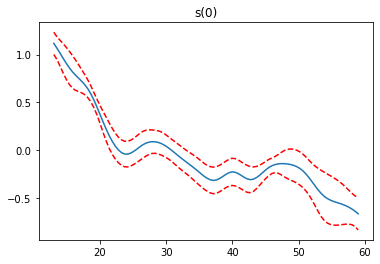

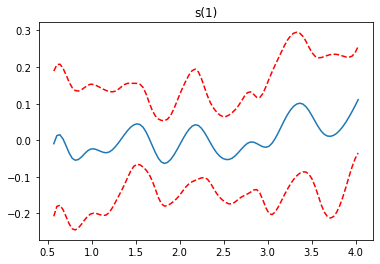

In [376]:
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(repr(term))
    plt.show()

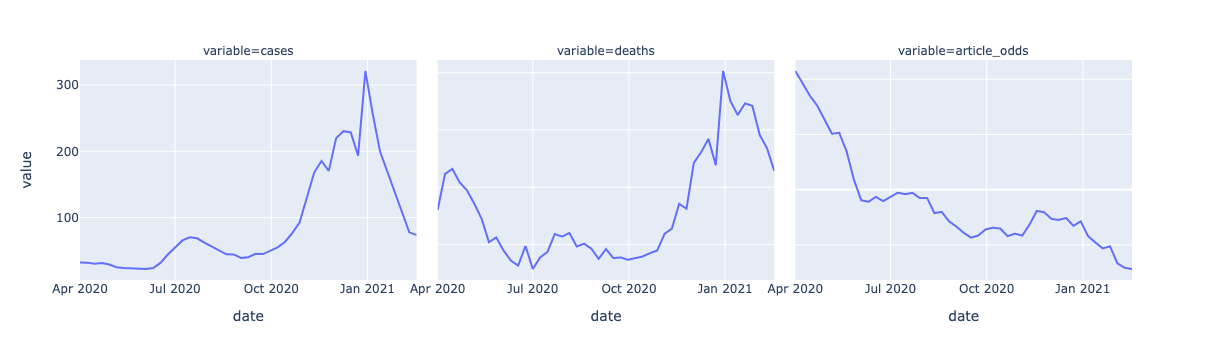

In [377]:
averaged_data = covid_df.groupby("date").agg(
        cases = pd.NamedAgg("country_n_cases_per1k","first"),
        deaths = pd.NamedAgg("country_n_deaths_per1k","first"),
        article_odds = pd.NamedAgg("log_odds_of_covid_article","mean")
).reset_index()
fig = px.line(pd.melt(averaged_data,id_vars="date"),x="date",y="value",facet_col="variable")
fig.update_yaxes(matches=None)
fig.show()